In this project, we can adopt the concept of quantum to encode the chrome of genetic algorithms. Suppose we are going to explore a continual space for several variables in order to get a maximal value for the object function.
$$f(x, y) = x^2 + y^2 -x - y$$

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
x = np.linspace(-1, 1, num=50)
y= np.linspace(-1, 1, num=50)

In [11]:
def objFunc(x, y):
    return x**2 + y**2 - x - y

In [12]:
u, v = np.meshgrid(x, y)
f = objFunc(u, v)

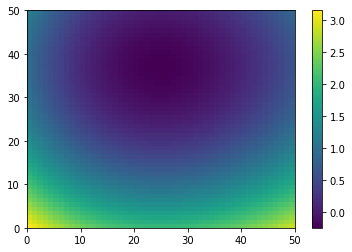

In [13]:
plt.pcolor(f)
plt.colorbar()

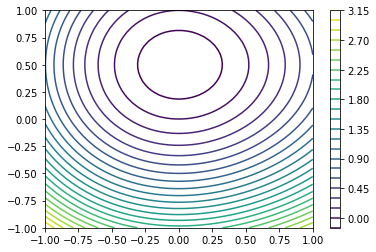

In [14]:
plt.contour(u, v, f, 30)
plt.colorbar()

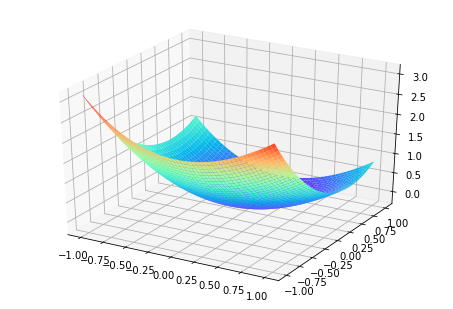

In [15]:
from mpl_toolkits.mplot3d import Axes3D
figure = plt.figure()
ax = Axes3D(figure)
ax.plot_surface(u, v, f, rstride=1, cstride=1, cmap='rainbow')

In [49]:
def encodingParameter(param_count=2, bit_len=7):
    '''
    Qubit encoding for parameters
    ArgsL
    param_count: number of parameters
    bit_len: bit length for each parameter
    '''
    degrees = np.pi/4 * np.ones((param_count, bit_len))
    chromosome = dict()
    chromosome['sin'] = np.sin(degrees)
    chromosome['cos'] = np.cos(degrees)
    chromosome['degree'] = degrees
    return chromosome

In [78]:
class individual:
    def __init__(self, chromosome):
        '''
        Args:
        chromosome: quantum qubit of genes, dictionary , ['sin':..,'cos':...,'degree':...]
        there's a dictinary within each list, including alpha, beta and angles
        '''
        self.chromosome = chromosome
        
    def collapse(self):
        '''
        Collapse a qubit into a state like [0 1 1 0]
        '''
        alpha = self.chromosome['sin']
        beta = self.chromosome['cos']
        pick = np.random.uniform(0, 1, alpha.shape)
        states = np.where(pick > alpha**2, 1, 0)
        return states
    
    def bin2decimal(self, state, bound=1):
        '''
        Map a binary state into a decimal value
        '''
        shape = state.shape
        bit_len = shape[-1]
        base = np.array([2**l for l in np.arange(bit_len)])
        values = np.dot(state, base)
        values = -bound + values/(2**bit_len-1)*2*bound
        return values
        
        
    def calFunc(self, variables):
        '''
        Calculate fitness for a given parameter combination
        '''
        x = variables[0]
        y = variables[1]
        f = x**2 + y**2 - x - y
        return f
    
    def calFitness(self, f):
        '''
        Transform the value into a non-negative fitness
        '''
        return 5 - f
    
    def proceed(self):
        states = self.collapse()
        values = self.bin2decimal(states)
        self.func = self.calFunc(values)
        self.fitness = self.calFitness(self.func)
        self.states = states
        self.values = values
        
        
        
    

In [79]:
chromosome = encodingParameter()
chromosome

{'cos': array([[ 0.70710678,  0.70710678,  0.70710678,  0.70710678,  0.70710678,
          0.70710678,  0.70710678],
        [ 0.70710678,  0.70710678,  0.70710678,  0.70710678,  0.70710678,
          0.70710678,  0.70710678]]),
 'degree': array([[ 0.78539816,  0.78539816,  0.78539816,  0.78539816,  0.78539816,
          0.78539816,  0.78539816],
        [ 0.78539816,  0.78539816,  0.78539816,  0.78539816,  0.78539816,
          0.78539816,  0.78539816]]),
 'sin': array([[ 0.70710678,  0.70710678,  0.70710678,  0.70710678,  0.70710678,
          0.70710678,  0.70710678],
        [ 0.70710678,  0.70710678,  0.70710678,  0.70710678,  0.70710678,
          0.70710678,  0.70710678]])}

In [80]:
obj = individual(chromosome)
obj.proceed()

In [81]:
obj.func

1.2891065782131561

In [82]:
class createPopulation:
    def __init__(self, pop_size=200):
        self.pop_size = pop_size
        
    def __initializeChromosome(self, param_count=2, bit_len=7):
        '''
        Qubit encoding for parameters
        Args:
        param_count: number of parameters
        bit_len: bit length for each parameter
        '''
        degrees = np.pi/4 * np.ones((param_count, bit_len))
        chromosome = dict()
        chromosome['sin'] = np.sin(degrees)
        chromosome['cos'] = np.cos(degrees)
        chromosome['degree'] = degrees
        return chromosome
    
    def generatePop(self):
        population = []
        for _ in np.arange(self.pop_size):
            chromosome = self.__initializeChromosome()
            obj = individual(chromosome)
            obj.proceed()
            population.append(obj)
        return population

In [107]:
pop = createPopulation(1000)
population = pop.generatePop()

In [108]:
class QuantumGeneticAlgorithm:
    def __init__(self, population):
        '''
        Initialize genetic algorithm
        '''
        self.population = population
        self.pop_size = len(population)
        
    def rotationAngleDirection(self, bestIndividual, obj):
        '''
        Calculate rotation angles and directions for each individual
        '''
        #Initialize the shift angle
        delta_theta = 0.01 * np.pi
        #Compare the fitness
        fitness_flag = obj.fitness > bestIndividual.fitness
        #Traverse each weight layer
        alpha = obj.chromosome['sin']
        #beta size: layer(i), layer(i+1), bit length
        beta = obj.chromosome['cos']
        #Original angles:
        degrees = obj.chromosome['degree']
        #state size: layer(i), layer(i+1), bit length
        #state, e.g [0 1 1 0]
        bit = obj.states
        #Traverse each parameter
        best_bit = bestIndividual.states
        #Search the table
        criteria = (bit + best_bit) == 1
        #Calculate shift angles for each parameter
        delta = criteria * delta_theta
        #Calculate the sign of shift angles
        sgns = np.zeros(bit.shape)#Initialize it with zeros
        #Try to avoid loops, use matrix operation as much as mossible
        #IF xi=0 besti=1, then the difference will be -1
        current_best_bit_flag = bit - best_bit
        #Create a matrix of fitness flag with the same shape as the weight
        fitness_flags = np.ones(bit.shape) * fitness_flag
        #Map 0 into -1
        fitness_flags = np.where(fitness_flags>0, 1, -1)
        alpha_beta_pos = (alpha * beta) > 0
        alpha_beta_neg = (alpha * beta) < 0
        alpha_zero = alpha == 0
        beta_zero = beta == 0
        #if alpha * beta>0
        sgns += current_best_bit_flag * fitness_flags * alpha_beta_pos
        #if alpha * beta<0
        sgns += (-1)*current_best_bit_flag * fitness_flags * alpha_beta_neg
        #if alpha = 0
        #Gnerate +1 -1 at random
        direction = np.random.choice([1, -1], size=bit.shape)
        criteria = current_best_bit_flag * fitness_flags * alpha_zero < 0
        sgns += criteria * direction
        #if beta = 0
        criteria = current_best_bit_flag * fitness_flags * beta_zero > 0
        sgns += criteria * direction
        #Calculate shift angles
        angles = delta * sgns
        #Calculate new angles
        degrees = degrees - angles
        obj.chromosome['sin'] = np.sin(degrees)
        obj.chromosome['cos'] = np.cos(degrees)
        obj.chromosome['degree'] = degrees
        obj.proceed()
        return obj
    
    def rotatingGates(self, bestIndividual_index):
        '''
        Rotate gates of quantum registra,
        Note, we try to make use of numpy's matrix operations to speed
        Computation
        Args:
        bestIndividual_index: the index of the best individual
        '''
        bestIndividual = self.population[bestIndividual_index]
        #Traverse each individual
        for i in np.arange(self.pop_size):
            obj = self.population[i]
            obj = self.rotationAngleDirection(bestIndividual, obj)
            self.population[i] = obj
            
    def NotGates(self, ratio=0.05):
        '''
        Rotate gates of quantum registra,
        Note, we try to make use of numpy's matrix operations to speed
        Computation
        Args:
        bestIndividual_index: the index of the best individual
        '''
        #Traverse each individual
        num = int(self.pop_size * ratio)
        indice = np.random.choice(self.pop_size, num)
        for i in indice:
            obj = self.population[i]
            obj = self.mutation(obj)
            self.population[i] = obj
            
    def mutation(self, obj):
        '''
        Mutation at several random point within an individual
        '''
        #Traverse each parameter in this layer
        #qubit contains alpha and beta
        #Alpha size: layer(i), layer(i+1), bit length
        #A qubit is a pair of alpha and beta
        alpha = obj.chromosome['sin']
        #beta size: layer(i), layer(i+1), bit length
        beta = obj.chromosome['cos']
        #Degrees
        degrees = obj.chromosome['degree']
        picks = np.random.uniform(0, 1, size=degrees.shape)
        #state size: layer(i), layer(i+1), bit length
        alpha_flag = alpha < picks
        beta_flag = beta < picks
        degrees = degrees - alpha_flag*beta_flag*np.pi/2
        obj.chromosome['sin'] = np.sin(degrees)
        obj.chromosome['cos'] = np.cos(degrees)
        obj.chromosome['degree'] = degrees
        obj.proceed()
        return obj
    
    def proceed(self, generation_num = 1):
        '''
        Execute quantum rotation and not gating
        '''
        #Keep the best individual
        best_fitness, optimal_index = self.findMaximalIndividual()
        best_individual = self.population[optimal_index]
        for _ in np.arange(generation_num):
            #Quantum Rotation Gate
            print('Best Fitness:', round(best_fitness, 4))
            self.rotatingGates(optimal_index)
            #Mutation
            self.NotGates()
            fitness, index = ga.findMaximalIndividual()
            if fitness < best_fitness:
                self.population[index] = best_individual
            else:
                best_fitness = fitness
                optimal_index = index
                best_individual = self.population[optimal_index]
        #return self.population
        
    def findMaximalIndividual(self):
        funcs = np.array([one.func for one in self.population])
        fitnesses = np.array([one.fitness for one in self.population])
        optimal_value = max(fitnesses)
        optimal_index = fitnesses.argmax()
        return optimal_value, optimal_index

In [109]:
ga = QuantumGeneticAlgorithm(population)
ga.proceed(200)

Best Fitness: 5.4995
Best Fitness: 5.4995
Best Fitness: 5.4995
Best Fitness: 5.4998
Best Fitness: 5.4998
Best Fitness: 5.4998
Best Fitness: 5.4998
Best Fitness: 5.4998
Best Fitness: 5.4998
Best Fitness: 5.4998
Best Fitness: 5.4998
Best Fitness: 5.4998
Best Fitness: 5.4998
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fitness: 5.5
Best Fi

In [89]:
population[0].func

1.7302994605989213